In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from astropy.io import fits
from astropy import units as u
from astropy.time import Time
from astropy.table import Table, join, vstack
from astropy.timeseries import BoxLeastSquares
from astropy.timeseries import aggregate_downsample
import warnings

os.environ['lref'] = './data/reference/references/hst/cos'

/Users/willyu/opt/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
# =============
# Read HST Data
# =============

# Select object
'''
Select from:
1. YZ_LMi
2. ASASSN_14mv
3. GP_Com
4. ASASSN_14cn
5. ZTF_J2252_0519
'''
object_name = 'ZTF_J2252_0519'
data_path = '../HST_DATA/'+object_name+'/'

corrtag_test = Table.read(data_path+'leqk41v4q_corrtag_a.fits')
print(corrtag_test.colnames)
print(corrtag_test, '\n')

print('IMPORTANT:', '\n',
      'There are primary and secondary headers.', '\n',
      'Change index before header to access difference sets of parameters!', '\n',
      '0: Primary headers, 1 or 2: Secondary headers.')
corrtag_test = fits.open(data_path+'leqk41v4q_corrtag_a.fits')
corrtag_headers = corrtag_test[1].header
corrtag_headers

['TIME', 'RAWX', 'RAWY', 'XCORR', 'YCORR', 'XDOPP', 'XFULL', 'YFULL', 'WAVELENGTH', 'EPSILON', 'DQ', 'PHA']
  TIME    RAWX RAWY   XCORR     YCORR   ... WAVELENGTH  EPSILON    DQ  PHA
   s      pix  pix     pix       pix    ...  Angstrom                     
-------- ----- ---- --------- --------- ... ---------- ---------- ---- ---
   0.032  5945  468 5929.1914 476.68765 ...  1213.6870 0.99224114    0   8
   0.064  5932  461 5917.1826 469.39697 ...  1212.7297  0.9925322    0   6
   0.064  5999  454 5983.7783 462.59656 ...  1218.0378  0.9909101    0   6
   0.064  5977  462  5961.033 469.32162 ...  1216.2249 0.99146634    0   8
   0.064  6018  458  6002.351 466.84113 ...  1219.5182 0.99047524    0   5
   0.064  6956  628  6933.061 651.79407 ...  1291.9597  0.9747554 4096  11
   0.064  5978  453 5962.8794  462.1744 ...  1216.3721   0.991418    0   4
   0.064  5990  454 5974.9287 463.15125 ...  1217.3325  0.9911277    0   3
   0.096  5953  461  5937.915 469.12326 ...  1214.3822 0.99202317  

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   39 / length of dimension 1                          
NAXIS2  =               165213 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                   12 / number of table fields                         
INHERIT =                    T / inherit the primary header                     
EXTNAME = 'EVENTS  '           / extension name                                 
EXTVER  =                    1 / extension version number                       
ROOTNAME= 'leqk41v4q                         ' / rootname of the observation set
EXPNAME = 'leqk41v4q        

In [3]:
# ======================
# Corrtag file operation
# ======================

# Import corrtag files
corrtag_files = sorted(glob.glob(data_path+'*corrtag*.fits'))

# Combine all corrtags files
ctags = []
for ctag in corrtag_files:
    warnings.filterwarnings('ignore')
    ctag_table = Table.read(ctag, 1)
    ctag_header = fits.open(ctag)[1].header
    ctag_table['MJD'] = (ctag_table['TIME']/86400 + ctag_header['EXPSTART'])/u.s*u.d
    print('Exposure starts:', ctag_header['EXPSTART'])
    # Append the table to the list of tables
    ctags.append(ctag_table)
ctag_combined = vstack(ctags)

# Import the spectrum
x1dsum = Table.read(data_path+'leqk41010_x1dsum.fits')

Exposure starts: 59900.74681923
Exposure starts: 59900.80318516
Exposure starts: 59900.86930775
Exposure starts: 59900.9354422
Exposure starts: 59901.00158775


Number of wavelength bands masked: 4


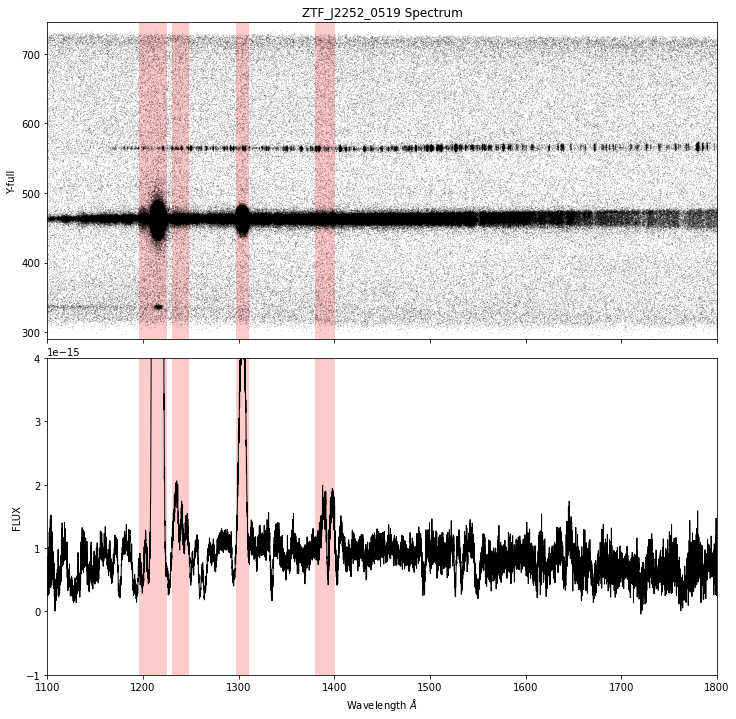

In [4]:
# =================
# Spectrum analysis
# =================

fig, axs = plt.subplots(2, figsize=(12, 12), gridspec_kw={'hspace':0.06}, sharex=True)
plt.setp(axs, xlim=(1100,1800))

axs[0].plot(ctag_combined['WAVELENGTH'], ctag_combined['YFULL'], '.', c='k', ms=0.1)
axs[1].plot(x1dsum['WAVELENGTH'].T, x1dsum['FLUX'].T, ls='-', lw=1, c='k')

axs[0].set_ylim(290, 745)
axs[1].set_ylim(-1e-15, 4e-15)
axs[1].set_xlabel('Wavelength $\AA$')
axs[0].set_ylabel('Y-full')
axs[1].set_ylabel('FLUX')
axs[0].set_title(object_name)
axs[0].set_title(object_name+' Spectrum')

# Select regions to cut in wavelength-space
wl_masks = [[1196, 1225], # geocoronal Ly-alpha
            [1297, 1311], # geocoronal O I
            [1230, 1248], 
            [1380, 1401]]
print('Number of wavelength bands masked:', len(wl_masks))

# Plot the regions to mask
for ax in axs:
    for wl in wl_masks:
        ax.axvspan(wl[0], wl[1], color='r', alpha=0.2, lw=0)
    
plt.show()

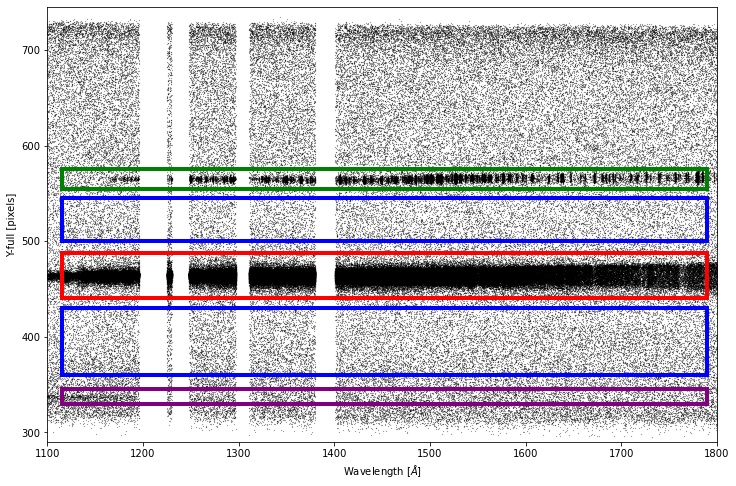

In [5]:
# +=======================
# Elements of corrtag file
# ========================

# Wavelength masking
ctag_masked = ctag_combined
for wl in wl_masks:
    mask = (ctag_masked['WAVELENGTH']>wl[0]) & (ctag_masked['WAVELENGTH']<wl[1])
    ctag_masked = ctag_masked[~mask]

# Original corrtag file
plt.figure(figsize=(12, 8))
plt.plot(ctag_masked['WAVELENGTH'], ctag_masked['YFULL'], '.', c='k', ms=0.3)
plt.xlim(1100,1800)
plt.ylim(290, 745)

# Wavelength lower & upper limit
wl_ll, wl_ul = 1115, 1790 # Choose wavelength lower and upper limits

# YFULL boundaries
y_bdr = [[440, 488], # Detection of star
         [555, 575], # Calibration lamp
         [500, 545], # Background I
         [360, 430], # Background II
         [330, 345]] # Geocoronal emission lines

color = ['red', 'green', 'blue', 'blue', 'purple']

for i in range(len(y_bdr)):
    plt.gca().add_patch(Rectangle((wl_ll, y_bdr[i][0]), 
                                  width=wl_ul-wl_ll, height=y_bdr[i][1]-y_bdr[i][0],
                                  ec=color[i], fc='none', lw=4, zorder=3))


plt.xlabel('Wavelength [$\AA$]')
plt.ylabel('Y-full [pixels]')
plt.show()

In [6]:
# =====================
# Generating lightcurve
# =====================

# Import masks
mask_star = ((ctag_masked['WAVELENGTH'] > wl_ll) & (ctag_masked['WAVELENGTH'] < wl_ul) &
             (ctag_masked['YFULL'] > y_bdr[0][0]) & (ctag_masked['YFULL'] < y_bdr[0][1]))

mask_bkgd1 = ((ctag_masked['WAVELENGTH'] > wl_ll) & (ctag_masked['WAVELENGTH'] < wl_ul) &
              (ctag_masked['YFULL'] > y_bdr[2][0]) & (ctag_masked['YFULL'] < y_bdr[2][1]))
mask_bkgd2 = ((ctag_masked['WAVELENGTH'] > wl_ll) & (ctag_masked['WAVELENGTH'] < wl_ul) &
              (ctag_masked['YFULL'] > y_bdr[3][0]) & (ctag_masked['YFULL'] < y_bdr[3][1]))

ctag_star = ctag_masked[mask_star]
ctag_bkgd = vstack([ctag_masked[mask_bkgd1], ctag_masked[mask_bkgd2]])
print(ctag_star)

# Binning the corrtag file and generate lightcurve pandas frame
binwidth = 3./86400 # <========= Set the bin-width in days
print('Set the bin width to:', binwidth*86400., 's')
bins = np.arange(np.min(ctag_star['MJD']), np.max(ctag_star['MJD'])+binwidth, binwidth)

hist_bkgd, bins = np.histogram(ctag_bkgd['MJD'], bins = bins)
hist_star, bins = np.histogram(ctag_star['MJD'], bins = bins)

bkgd_scale = (y_bdr[0][1]-y_bdr[0][0]) / ((y_bdr[2][1]-y_bdr[2][0])+(y_bdr[3][1]-y_bdr[3][0]))

lc = pd.DataFrame({'mjd': bins[:-1], 
                   'count': hist_star - hist_bkgd*bkgd_scale, 
                   'count_error': np.sqrt(np.sqrt(hist_star)**2 + np.sqrt(hist_bkgd)**2)})
lc = lc.loc[lc['count'] > 0]

  TIME    RAWX RAWY   XCORR   ...  EPSILON    DQ PHA        MJD        
   s      pix  pix     pix    ...                            d         
-------- ----- ---- --------- ... ---------- --- --- ------------------
    0.16  8670  459  8636.929 ...  0.9571736   0   5 59900.746821081855
   0.192  7410  462 7383.1816 ...  0.9668978   0   8  59900.74682145222
   0.192  7750  459  7722.517 ... 0.96078306   0   8  59900.74682145222
   0.256  6449  456 6428.3286 ...  0.9815669   0   5  59900.74682219297
   0.288  9918  468  9866.786 ... 0.95406526   0   9 59900.746822563335
   0.288  5487  456 5474.5435 ...  1.0026282   0   7 59900.746822563335
   0.288  8445  455  8415.749 ... 0.95750546   0   7 59900.746822563335
   0.384  7233  454  7207.623 ...   0.970324   0   6 59900.746823674446
   0.384  5413  455  5401.603 ...   1.263044   4   6 59900.746823674446
   0.416  5525  456  5512.379 ...  1.0018494   0   4 59900.746824044814
     ...   ...  ...       ... ...        ... ... ...            

In [7]:
# Save Binned lightcurve
mjd         = lc['mjd']
count       = lc['count']
count_error = lc['count_error']
ones        = np.ones(len(mjd))
exp         = np.ones(len(mjd))*binwidth # exposure time for individual data point

# Write arrays in txt file
header = "MJD EXP COUNT COUNT_ERROR ONES ONES"
file_name  = str(object_name + '_lc.txt')
print('file save as:', file_name, '\n')
with open(file_name, 'w') as f: 
    f.write(header + "\n")
    for mjd,exp,count,count_error,ones,ones in zip(
        mjd,exp,count,count_error,ones,ones): 
        f.write(f"{mjd} {exp} {count} {count_error} {ones} {ones}\n")

file save as: ZTF_J2252_0519_lc.txt 



       MJD                  EXP                COUNT        ... ONES ONES_1
------------------ --------------------- ------------------ ... ---- ------
59900.746821081855 3.472222222222222e-05  62.07826086956522 ...  1.0    1.0
 59900.74685580408 3.472222222222222e-05 61.243478260869566 ...  1.0    1.0
  59900.7468905263 3.472222222222222e-05 62.495652173913044 ...  1.0    1.0
59900.746925248524 3.472222222222222e-05  77.49565217391304 ...  1.0    1.0
 59900.74695997075 3.472222222222222e-05  51.91304347826087 ...  1.0    1.0
 59900.74699469297 3.472222222222222e-05  62.99130434782609 ...  1.0    1.0
 59900.74702941519 3.472222222222222e-05 50.165217391304346 ...  1.0    1.0
 59900.74706413742 3.472222222222222e-05  51.66086956521739 ...  1.0    1.0
 59900.74709885964 3.472222222222222e-05  49.07826086956522 ...  1.0    1.0
 59900.74713358186 3.472222222222222e-05  41.91304347826087 ...  1.0    1.0
               ...                   ...                ... ...  ...    ...
59901.029772

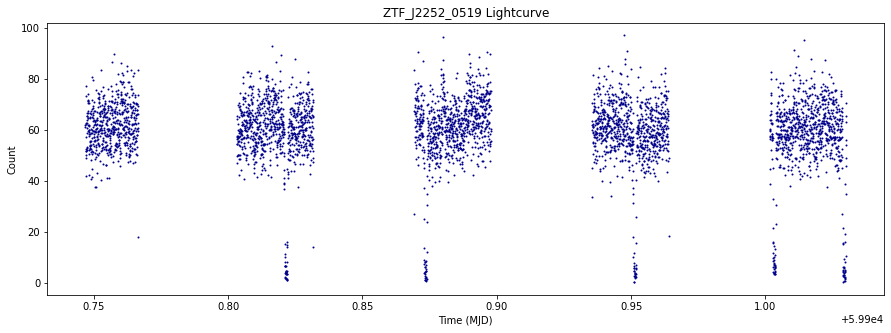

In [8]:
# Check lightcurve file and plot
lc = Table.read(file_name, format='ascii')
print(lc)

plt.figure(figsize=(15, 5))
plt.plot(lc['MJD'], lc['COUNT'], '.', c='darkblue', ms=2)
plt.xlabel('Time (MJD)')
plt.ylabel('Count')
plt.title(object_name+' Lightcurve')
plt.show()